In [1]:
#!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
#!python -c "import matplotlib" || pip install -q matplotlib
#!pip install -U scikit-learn

In [2]:
#Setup imports
import monai
import matplotlib
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

c:\Users\56991\anaconda3\envs\MONAI\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.9.0
Numpy version: 1.21.5
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: af0e0e9f757558d144b655c63afcea3a4e0a06f5
MONAI __file__: c:\Users\56991\anaconda3\envs\MONAI\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.10.0
gdown version: 4.5.1
TorchVision version: 0.13.1
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
#Setup data directory
#You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.
#This allows you to save results and reuse downloads.
#If not specified a temporary directory will be used.
os.environ["MONAI_DATA_DIRECTORY"] = "C:\\Users\\56991\\OneDrive\\PhD\\data"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(directory)
print(root_dir)

C:\Users\56991\OneDrive\PhD\data
C:\Users\56991\OneDrive\PhD\data


In [4]:
#Download dataset
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz") #add the word to path
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)
set_determinism(seed=0)

# Read image filenames from the dataset folders
* First of all, check the dataset files and show some statistics.
* data_dir=C:\\Users\\56991\\OneDrive\\PhD\\data\\MedNIST



In [5]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)

#一个接一个把六个文件夹里的所有图像添加在images_files列表中，images_files有六个子列表，代表每个类型
#num_each就是每个类型拥有的图片数量
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]

In [6]:
#imagefileslist和imagefiles的区别: imagefileslist把六个子list的元素联结在一起了
#imageclass就是记录每个image的类型的列表，和Imagefileslist是对应的，六个类型用012345记录
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

* 总结：

    数据主目录 data_dir=C:\\Users\\56991\\OneDrive\\PhD\\data\\MedNIST
    
    class_names就是这个目录下所有的文件夹名称放到这个列表里，也就是代表有6类图像：

    ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
    
    which should be used as the labels to train our classification model.

    class_names 主目录下文件夹名称，也就是六种类型

    images_files 存储图像路径的列表，这个列表有六个子列表，存储每个类型的图像名称路径

    image_files_list 把六个子list的元素联结在一起了

    num_each 每个类型拥有的图片数量
    
    image_class 就是记录每个image的类型的列表

In [7]:

print(type(class_names),' size', len(class_names))
print(type(image_files[0]),' size', len(image_files))
print(type(image_files_list), len(image_files_list),image_files_list[10002])
print(type(image_class), len(image_class),image_class[10002])

print(f"Total image count: {num_total}") #前面有一个f，就不会输出{}大括号了
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

<class 'list'>  size 6
<class 'list'>  size 6
<class 'list'> 58954 C:\Users\56991\OneDrive\PhD\data\MedNIST\BreastMRI\000002.jpeg
<class 'list'> 58954 1
Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


* Randomly pick images from the dataset to visualize and check

AbdomenCT
Hand
Hand
HeadCT
Hand
CXR
ChestCT
ChestCT
Hand


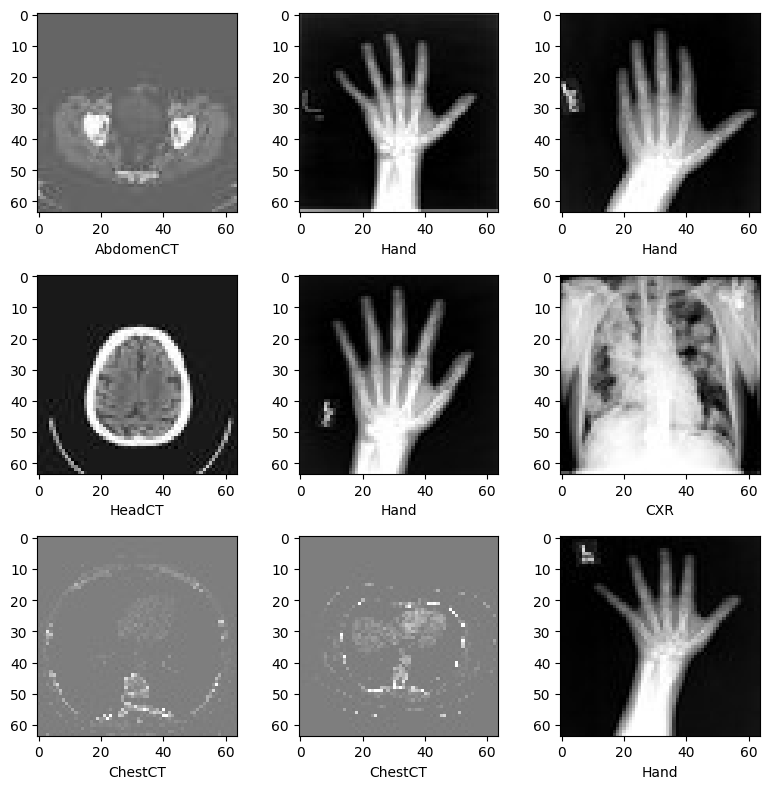

In [8]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]]) #str(i),
    print(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

# Prepare training, validation and test data lists
* Randomly select 10% of the dataset as validation and 10% as test.

In [9]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


In [10]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

# torch.utils.data.Dataset : initialize the form of dataset
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

#if __name__ == "__main__":
train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=300, shuffle=True, num_workers=0)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=300, num_workers=0)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(
    test_ds, batch_size=300, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1,
                    out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

In [11]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs) 
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/4


RuntimeError: applying transform <monai.transforms.utility.array.EnsureChannelFirst object at 0x0000016B6C293E08>

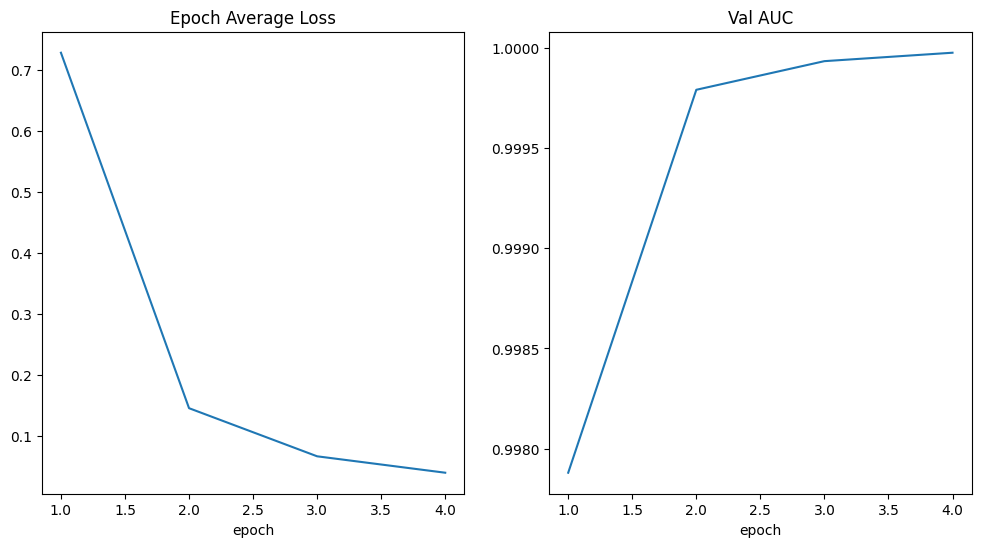

In [ ]:
#Plot the loss and metric
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [ ]:
#Evaluate the model on test dataset
#After training and validation, we already got the best model on validation test.
#We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.
#We'll use these predictions to generate a classification report.
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9910    0.9950    0.9930       995
   BreastMRI     0.9943    0.9898    0.9920       880
         CXR     0.9990    0.9969    0.9980       982
     ChestCT     0.9931    1.0000    0.9966      1014
        Hand     0.9981    0.9933    0.9957      1048
      HeadCT     0.9990    0.9990    0.9990       976

    accuracy                         0.9958      5895
   macro avg     0.9957    0.9957    0.9957      5895
weighted avg     0.9958    0.9958    0.9958      5895



In [ ]:
#Cleanup data directory
#Remove directory if a temporary was used
if directory is None:
    shutil.rmtree(root_dir)

In [ ]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Mar_21_19:24:09_Pacific_Daylight_Time_2021
Cuda compilation tools, release 11.3, V11.3.58
Build cuda_11.3.r11.3/compiler.29745058_0
